# Final Figures for PIK3CA Story
### Phosphorylation levels

##### These notebooks are used to create the figures used for our PIK3CA story. For more detailed analysis of what is being done, see Notebook 2 in this folder.

### Standard Imports

In [1]:
import pandas as pd
import numpy as np
import re
import scipy.stats
import statsmodels.stats.multitest
import matplotlib.pyplot as plt
import seaborn as sns
import json
import operator

#import the Endometrial data from CPTAC package
import CPTAC.Endometrial as CPTAC

Welcome to the CPTAC data service package. This import contains
information about the package. In order to access a specific data set,
import a CPTAC subfolder by either 'import CPTAC.DataName' or 'from
CPTAC import DataName'.
Loading Endometrial CPTAC data:
Loading Dictionary...
Loading Clinical Data...
Loading Proteomics Data...
Loading Transcriptomics Data...
Loading CNA Data...
Loading Phosphoproteomics Data...
Loading Somatic Mutation Data...

 ******PLEASE READ******
CPTAC is a community resource project and data are made available
rapidly after generation for community research use. The embargo
allows exploring and utilizing the data, but the data may not be in a
publication until July 1, 2019. Please see
https://proteomics.cancer.gov/data-portal/about/data-use-agreement or
enter embargo() to open the webpage for more details.


### Get phosphorylation data and somatic mutations from CPTAC

In [2]:
somatic = CPTAC.get_somatic()
phos = CPTAC.get_phosphoproteomics()

### Make Phosphoproteomics box plot for AKT1, AKT2, PTEN, PIK3CA
##### Show data for hotspot mutations vs wildtype in cancer patients, showing most significant site in each protein

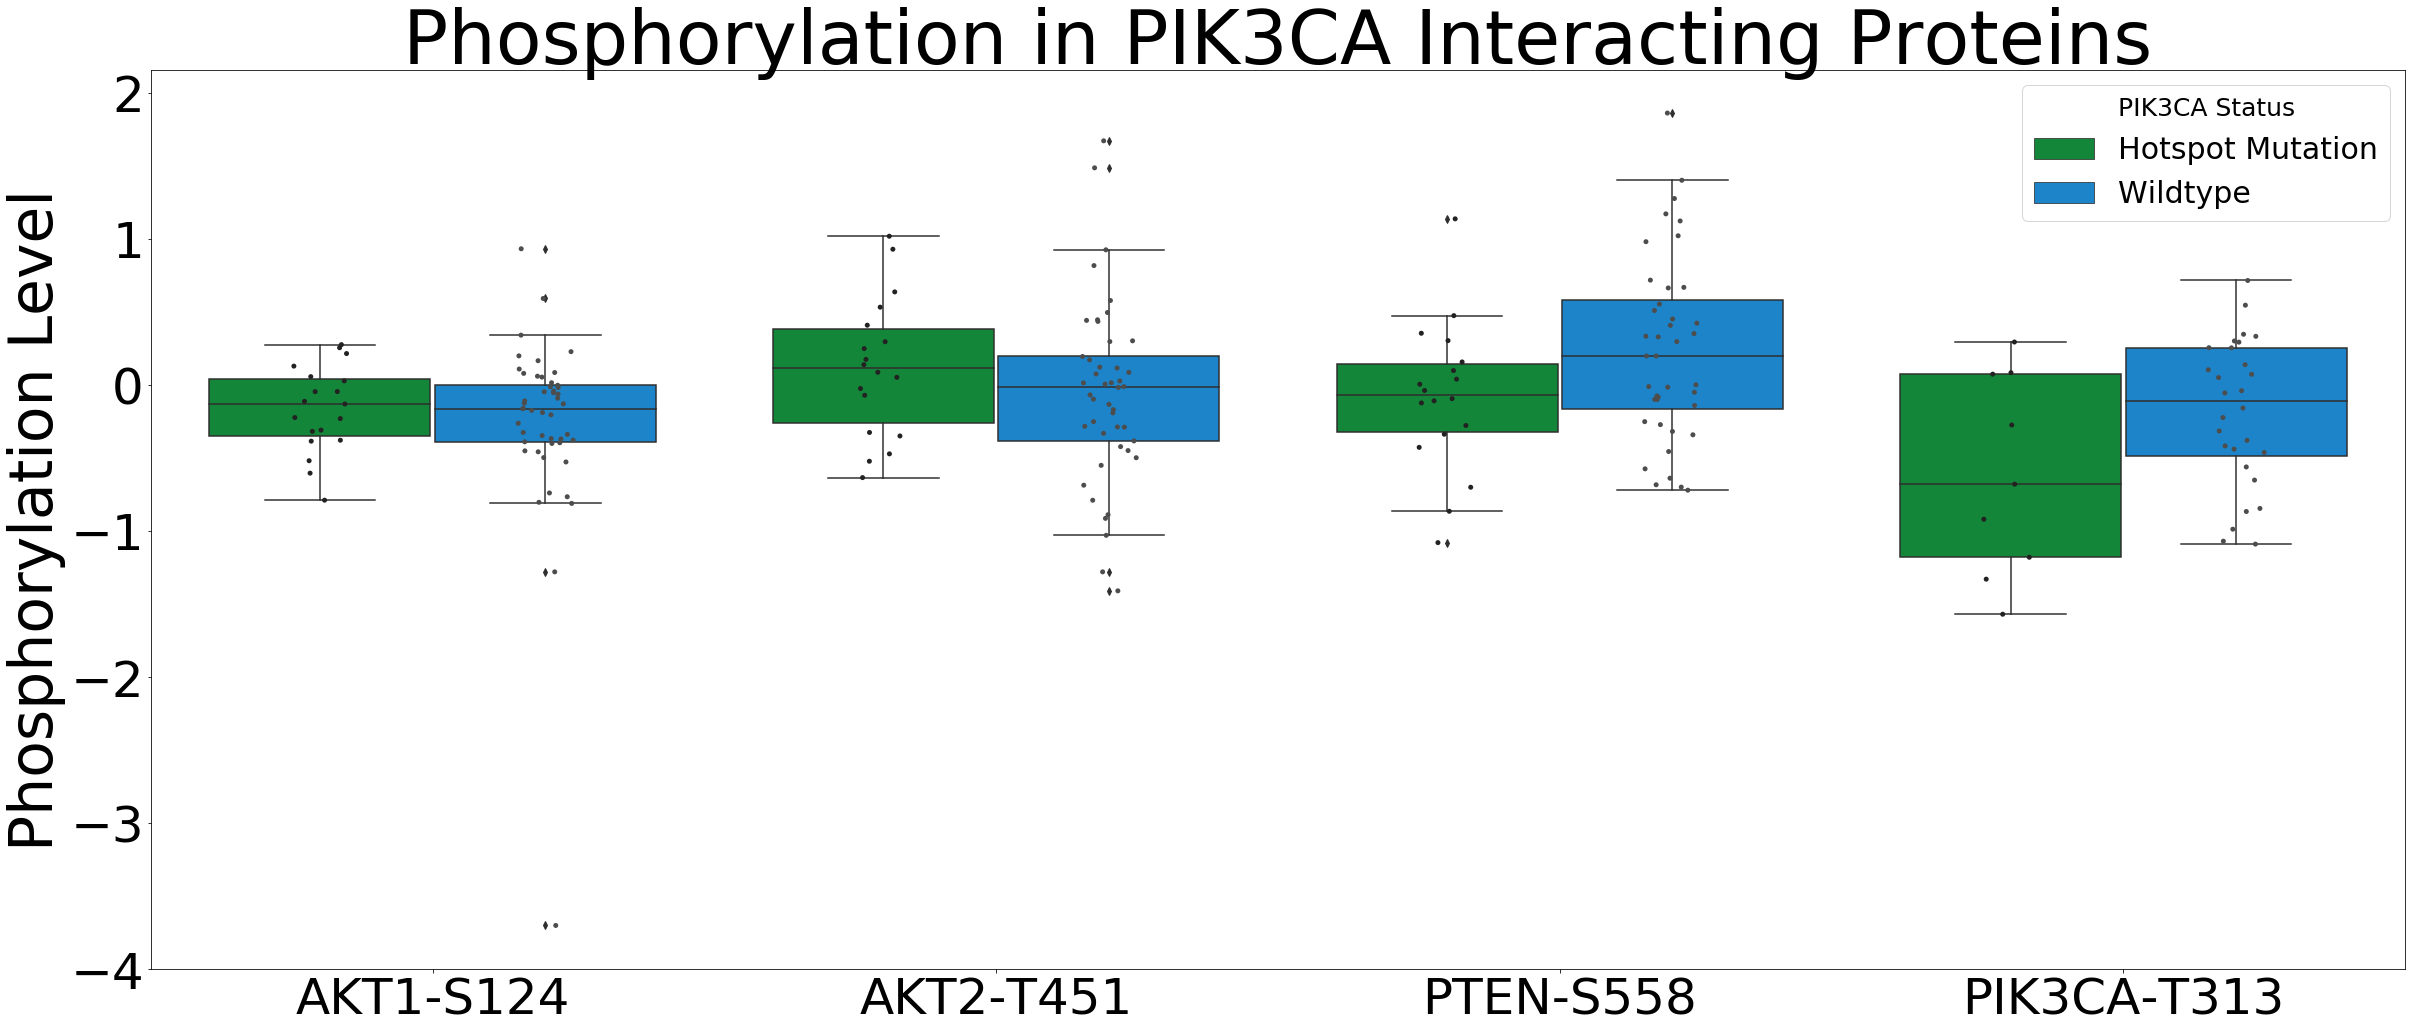

In [9]:
'''Use PIK3CA as gene, AKT1, AKT2, PTEN, and PIK3CA as proteins'''
gene = 'PIK3CA'
protList = ['AKT1','AKT2','PTEN','PIK3CA']

'''A list of mutations present in the hotspot according to our Hotspot3D output'''
hotspot_mutations = ['p.E545A', 'p.E545K', 'p.E545V', 'p.Q546P', 'p.Q546R', 'p.E542K']
mutated_hotspot = somatic.loc[(somatic['Location'].isin(hotspot_mutations)) & (somatic['Gene'] == gene)]
hotspot_patients = mutated_hotspot['Clinical_Patient_Key']

'''Get the PIK3CA mutation dataframe'''
plotdf = CPTAC.compare_mutations(phos, gene)

'''Look only at Tumor patients'''
plotdf = plotdf.loc[plotdf['Patient_Type'] == 'Tumor'][['Mutation']]

'''Add in the protein levels for every protein in the list'''
for protein in protList:
    proteindf = CPTAC.compare_mutations(phos, protein, gene)
    proteindf = proteindf.loc[proteindf['Patient_Type'] == 'Tumor']
    for site in proteindf:
        if site != 'Mutation' and site != 'Patient_Type':
            plotdf = plotdf.join(proteindf[site])
            
            
'''Reformat the dataframe to classify Hotspot Mutations, and all other types'''
for ind, row in plotdf.iterrows():
    if ind in hotspot_patients.values:
        plotdf.at[ind, 'Mutation'] = 'Hotspot Mutation'
    else:
        if row['Mutation'] != 'Wildtype':
            plotdf.at[ind, 'Mutation'] = 'Non-Hotspot Mutation'
    
'''Select only hotspot mutation and wildtype'''
plotdf = plotdf.loc[plotdf['Mutation'] != 'Non-Hotspot Mutation']

'''Do a t-test, comparing hotspot mutation and wildtype groups, to determine significance of each site'''
significance_of_sites = {}
for site in plotdf:
    if site != 'Mutation':
        hotspotdf = plotdf.loc[plotdf['Mutation'] == 'Hotspot Mutation'][['Mutation', site]]
        hotspotdf = hotspotdf.dropna(axis=0)
        otherdf = plotdf.loc[plotdf['Mutation'] != 'Hotspot Mutation'][['Mutation', site]]
        otherdf = otherdf.dropna(axis=0)
        ttest = scipy.stats.ttest_ind(hotspotdf[site], otherdf[site])
        significance_of_sites[site]=ttest[1]

'''Record the most significant site in each protein'''
mostSignificantPhosphorylationSites = ['Mutation','AKT1-S124','AKT2-T451','PTEN-S558','PIK3CA-T313']
plotdf = plotdf[mostSignificantPhosphorylationSites]

'''Create a new dataframe for only these 4 phosphorylation sites'''
plotdf = pd.melt(plotdf, id_vars=['Mutation'], var_name='Phosphorylation Site', value_name='Signal')
plotdf = plotdf.dropna(axis=0)

'''Create the plot'''
a4_dims = (40.4, 16.54)
fig, ax = plt.subplots(figsize=a4_dims)
my_pal = {"Hotspot Mutation": "#009933", "Wildtype": "#008ae6"}
boxplt = sns.boxplot(x='Phosphorylation Site', y='Signal', hue='Mutation', data=plotdf, palette=my_pal)
boxplt = sns.stripplot(data=plotdf, x='Phosphorylation Site', y='Signal', hue='Mutation', dodge=True, jitter=True, color='.3')
boxplt.set_xlabel('')
boxplt.set_ylabel('Phosphorylation Level', fontsize='60')
boxplt.tick_params(labelsize='50')
boxplt.set_title('Phosphorylation in PIK3CA Interacting Proteins', fontsize = '75')

'''Adjust the legend'''
handles, labels = ax.get_legend_handles_labels()
plt.legend(handles[0:2], ['Hotspot Mutation', 'Wildtype'], title='PIK3CA Status', fontsize='30', frameon=True)
boxplt.get_legend().get_title().set_fontsize('25')

'''Show Plot'''
fig = boxplt.get_figure()
plt.show()

## Phosphoproteomics Volcano Plot
#### Hotspot mutation vs wildtype in cancer patients, all phosphorylation sites in all interacting proteins

/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3157: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:132: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


0.00022935779816513763


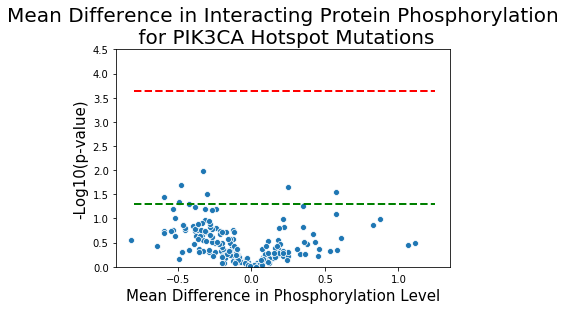

In [10]:
'''Use PIK3CA as gene, AKT1, AKT2, PTEN, and PIK3CA as proteins'''
gene = 'PIK3CA'
protList = protList = ['IRS1', 'IRS2', 'RRAS', 'AKT2', 'NRAS', 'PTEN', 'AKT1', 'RPS6KB1', 'PIK3R1', 'PIK3CA','MTOR', 'ERBB3', 'CDK5']

'''A list of mutations present in the hotspot according to our Hotspot3D output'''
hotspot_mutations = ['p.E545A', 'p.E545K', 'p.E545V', 'p.Q546P', 'p.Q546R', 'p.E542K']
mutated_hotspot = somatic.loc[(somatic['Location'].isin(hotspot_mutations)) & (somatic['Gene'] == gene)]
hotspot_patients = mutated_hotspot['Clinical_Patient_Key']

'''Get the PIK3CA mutation dataframe'''
plotdf = CPTAC.compare_mutations(phos, gene)

'''Look only at Tumor patients'''
plotdf = plotdf.loc[plotdf['Patient_Type'] == 'Tumor'][['Mutation']]

'''Add in the phosphorylation levels for every phosphosite in the list'''
for protein in protList:
    proteindf = CPTAC.compare_mutations(phos, protein, gene)
    proteindf = proteindf.loc[proteindf['Patient_Type'] == 'Tumor']
    for site in proteindf:
        if site != 'Mutation' and site != 'Patient_Type':
            plotdf = plotdf.join(proteindf[site])
                 
'''Reformat the dataframe to classify Hotspot Mutations, and all other types'''
for ind, row in plotdf.iterrows():
    if ind in hotspot_patients.values:
        plotdf.at[ind, 'Mutation'] = 'Hotspot Mutation'
    else:
        if row['Mutation'] != 'Wildtype':
            plotdf.at[ind, 'Mutation'] = 'Non-Hotspot Mutation'
    
'''Select only hotspot mutation and wildtype'''
plotdf = plotdf.loc[plotdf['Mutation'] != 'Non-Hotspot Mutation']

        
p_values = []
mean_diffs = []
p_val_mean_diff_dict = {}
'''Get mean difference in phosphorylation level between hotspot and wildtype groups, as well as p-value'''
for site in plotdf:
    if site != 'Mutation':
        '''Record the p-value'''
        hotspotdf = plotdf.loc[plotdf['Mutation'] == 'Hotspot Mutation'][['Mutation', site]]
        hotspotdf = hotspotdf.dropna(axis=0)
        otherdf = plotdf.loc[plotdf['Mutation'] != 'Hotspot Mutation'][['Mutation', site]]
        otherdf = otherdf.dropna(axis=0)
        ttest = scipy.stats.ttest_ind(hotspotdf[site], otherdf[site])
        p_values.append(ttest[1])
        
        '''Record the mean difference in phosphorylation level'''
        diff_mean = np.mean(hotspotdf[site]) - np.mean(otherdf[site])
        mean_diffs.append(diff_mean)
        p_val_mean_diff_dict[site] = [ttest[1], diff_mean]
        
'''Record the negative log of each p-value, for our volcano plot'''
neg_log_pvals = []
plot_diff_means = []
for key in p_val_mean_diff_dict.keys():
    if np.nan in p_val_mean_diff_dict[key]:
        p_val_mean_diff_dict[key] = []
    else:
        neg_log_pvals.append(-1 * np.log10(p_val_mean_diff_dict[key][0]))
        plot_diff_means.append(p_val_mean_diff_dict[key][1])
        
'''Create a line of the bonferroni corrected p-value cutoff for our volcano plot'''
bonferroni_cutoff = .05/len(neg_log_pvals)
print(bonferroni_cutoff)
cutoffLine = (-1 * np.log10(bonferroni_cutoff))
unadjustedPvalLine = (-1 * np.log10(.05))
   
'''Reformat data in dataframe for our plot'''
df = pd.DataFrame({'-Log10(p-value)': neg_log_pvals, 'Mean Difference in Phosphorylation Level':plot_diff_means})

'''Create and display the plot'''
ax = sns.scatterplot(x = "Mean Difference in Phosphorylation Level", y = "-Log10(p-value)", data =df)
ax.set_title("Mean Difference in Interacting Protein Phosphorylation\n for PIK3CA Hotspot Mutations", fontsize = '20')
ax.set_xlabel('Mean Difference in Phosphorylation Level', fontsize = '15')
ax.set_ylabel('-Log10(p-value)', fontsize='15')
ax.plot([-.8,1.25],[cutoffLine,cutoffLine], linewidth=2,linestyle="--", color="red")
ax.plot([-.8,1.25],[unadjustedPvalLine, unadjustedPvalLine], linewidth=2,linestyle="--", color="green")
ax.set(ylim=(0, 4.5))
plt.show()